,session,bird,n_resp_left,n_resp_right,n_reinf_left,n_reinf_right,dynamic_env
,<chr>,<chr>,<int>,<int>,<int>,<int>,<lgl>
901,s01,p736,216,153,19,8,FALSE
902,s02,p736,605,44,31,3,FALSE
903,s03,p736,672,70,27,5,FALSE


[1] 136   7

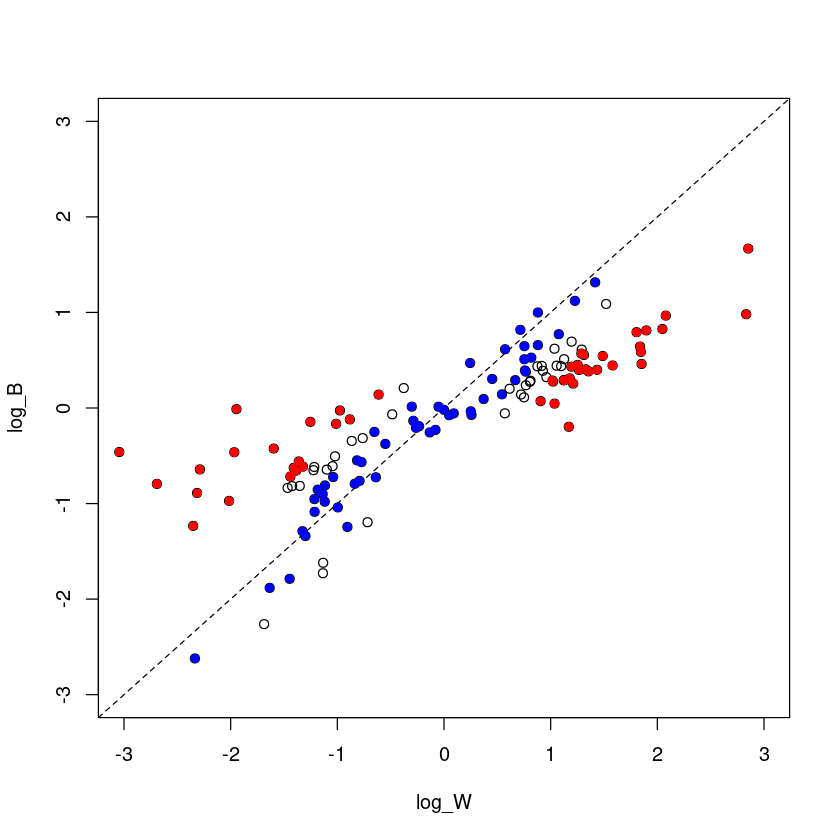

In [43]:
equilibrium <- read.csv('~/ResearchProjects/JAPE/ConcurrentData/matching_by_session.csv')
stable <- subset(equilibrium,!dynamic_env)

bb <- unique(stable$bird)[6]
bb_stable <- subset(stable,bird==bb)
head(bb_stable,3)
dim(bb_stable)

bb_stable <- bb_stable[-c(4,9),] # Leverage/Outliers

log_W <- log(bb_stable$n_reinf_right/bb_stable$n_reinf_left)
log_B <- log(bb_stable$n_resp_right/bb_stable$n_resp_left)


distances <- abs(-log_W+log_B)/sqrt(2)

n_select <- 50
W_r <- array(dim=c(n_select,2))
W_l <- array(dim=c(n_select,2))
B_r <- array(dim=c(n_select,2))
B_l <- array(dim=c(n_select,2))
# Closer to matching:
W_r[,1] <- bb_stable$n_reinf_right[order(distances,decreasing=F)][1:n_select]
W_l[,1] <- bb_stable$n_reinf_left[order(distances,decreasing=F)][1:n_select]
B_r[,1] <- bb_stable$n_resp_right[order(distances,decreasing=F)][1:n_select]
B_l[,1] <- bb_stable$n_resp_left[order(distances,decreasing=F)][1:n_select]
# Farther from matching:
W_r[,2] <- bb_stable$n_reinf_right[order(distances,decreasing=T)][1:n_select]
W_l[,2] <- bb_stable$n_reinf_left[order(distances,decreasing=T)][1:n_select]
B_r[,2] <- bb_stable$n_resp_right[order(distances,decreasing=T)][1:n_select]
B_l[,2] <- bb_stable$n_resp_left[order(distances,decreasing=T)][1:n_select]



plot(log_W,log_B,
     xlim=c(-3,3),ylim=c(-3,3));abline(0,1,lty='dashed')
points(log(W_r[,1]/W_l[,1]),
       log(B_r[,1]/B_l[,1]),pch=16,col='blue')
points(log(W_r[,2]/W_l[,2]),
       log(B_r[,2]/B_l[,2]),pch=16,col='red')
# points(log_W[order(distances)][1:50],
#        log_B[order(distances)][1:50],pch=16,col='blue')
# points(log_W[order(distances,decreasing=T)][1:50],
#        log_B[order(distances,decreasing=T)][1:50],pch=16,col='red')
# text(log_W,log_B,pch=paste(1:length(log_W)),cex=1.5)

In [45]:
library('R2jags')

In [49]:
observed <- list('W_r','W_l','B_r','B_l','n_select')
unobserved <- c('mu_lambda_l_post','sigma_lambda_l_post','mu_lambda_r_post','sigma_lambda_r_post',
                'mu_gamma_l_post','sigma_gamma_l_post','mu_gamma_r_post','sigma_gamma_r_post',
                'lambda_l_post','lambda_r_post',
                'gamma_l_post','gamma_r_post')

In [73]:
write('

model{
    for(j in 1:2){ # Matching conditions

        mu_lambda_r_post[j]~dnorm(0,1)
        mu_lambda_l_post[j]~dnorm(0,1)
        mu_gamma_r_post[j]~dnorm(0,1)
        mu_gamma_l_post[j]~dnorm(0,1)
        sigma_lambda_r_post[j]~dunif(0,10)
        sigma_lambda_l_post[j]~dunif(0,10)
        sigma_gamma_r_post[j]~dunif(0,10)
        sigma_gamma_l_post[j]~dunif(0,10)
        tau_lambda_r_post[j] <- 1/sigma_lambda_r_post[j]^2
        tau_lambda_l_post[j] <- 1/sigma_lambda_l_post[j]^2
        tau_gamma_r_post[j] <- 1/sigma_gamma_r_post[j]^2
        tau_gamma_l_post[j] <- 1/sigma_gamma_l_post[j]^2

        for(i in 1:n_select){ # Observations within conditions

            lambda_r_post[i,j]~dlnorm(mu_lambda_r_post[j],tau_lambda_r_post[j])
            lambda_l_post[i,j]~dlnorm(mu_lambda_l_post[j],tau_lambda_l_post[j])
            gamma_r_post[i,j]~dlnorm(mu_gamma_r_post[j],tau_gamma_r_post[j])
            gamma_l_post[i,j]~dlnorm(mu_gamma_l_post[j],tau_gamma_l_post[j])
            
            # Observed
            W_r[i,j]~dpois(gamma_r_post[i,j])
            W_l[i,j]~dpois(gamma_l_post[i,j])
            B_r[i,j]~dpois(lambda_r_post[i,j])
            B_l[i,j]~dpois(lambda_l_post[i,j])

        }
    }
}

','jamm.bug') # Just Another Matching Model

bayes <- jags(data = observed,
              parameters.to.save=unobserved,
              model.file='jamm.bug')
unlink('jamm.bug')
summary(bayes$BUGSoutput$summary[,c('Rhat','n.eff')])

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 400
   Unobserved stochastic nodes: 416
   Total graph size: 837

Initializing model



      Rhat           n.eff     
 Min.   :1.001   Min.   : 290  
 1st Qu.:1.001   1st Qu.:1300  
 Median :1.002   Median :2500  
 Mean   :1.002   Mean   :2144  
 3rd Qu.:1.002   3rd Qu.:3000  
 Max.   :1.008   Max.   :3000  

In [75]:
nds_bayes <- bayes$BUGSoutput$sims.list
names(nds_bayes)

[1] "deviance"            "gamma_l_post"        "gamma_r_post"       
 [4] "lambda_l_post"       "lambda_r_post"       "mu_gamma_l_post"    
 [7] "mu_gamma_r_post"     "mu_lambda_l_post"    "mu_lambda_r_post"   
[10] "sigma_gamma_l_post"  "sigma_gamma_r_post"  "sigma_lambda_l_post"
[13] "sigma_lambda_r_post"

In [76]:
dim(nds$gamma_l_post)

[1] 3000   50    2

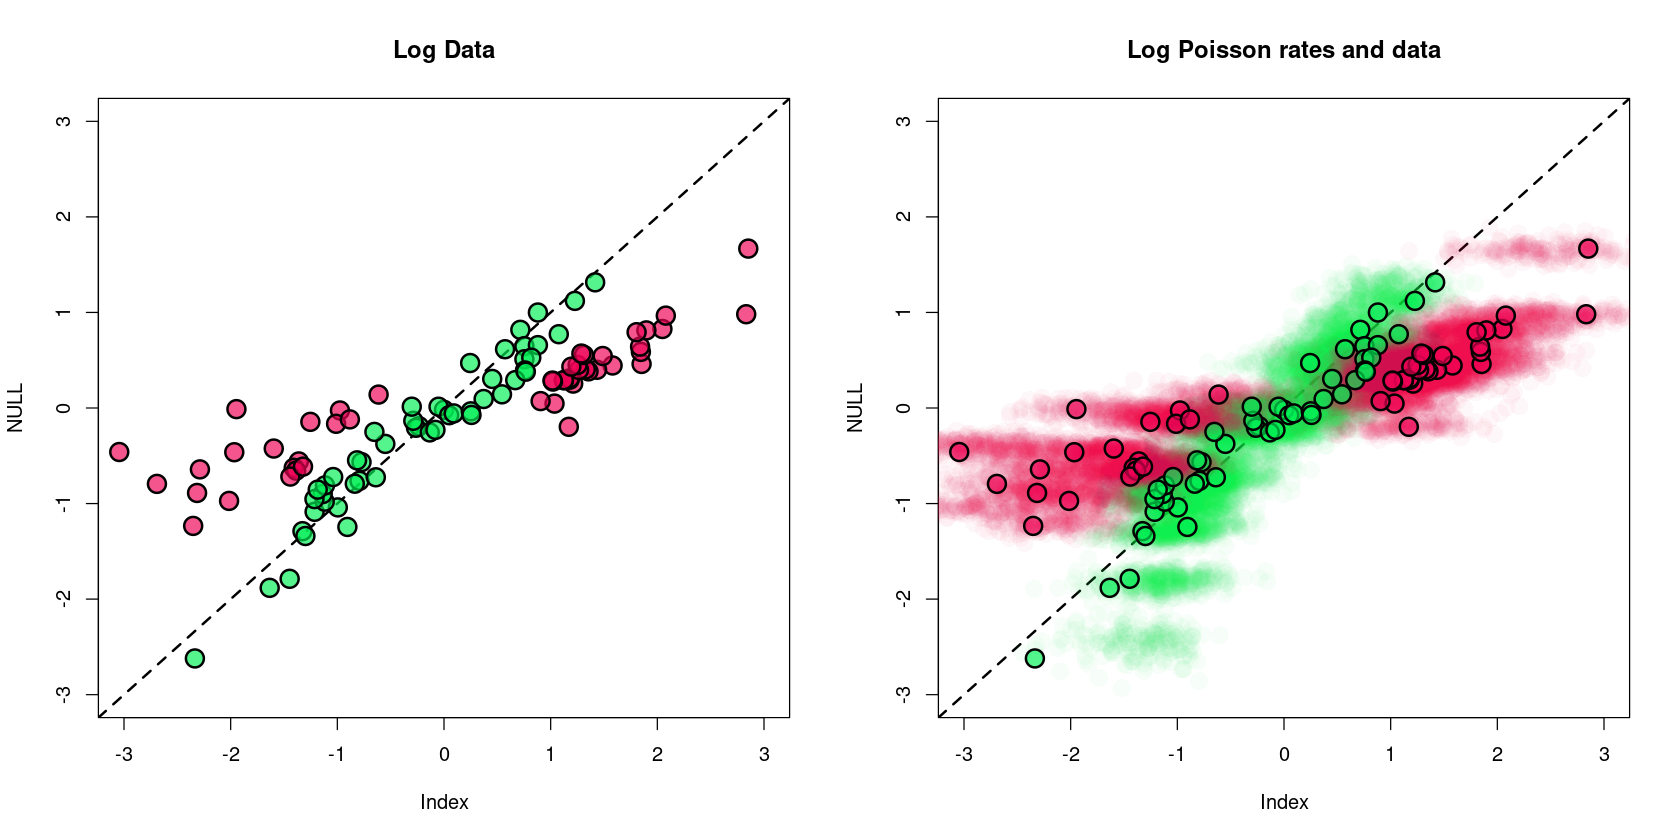

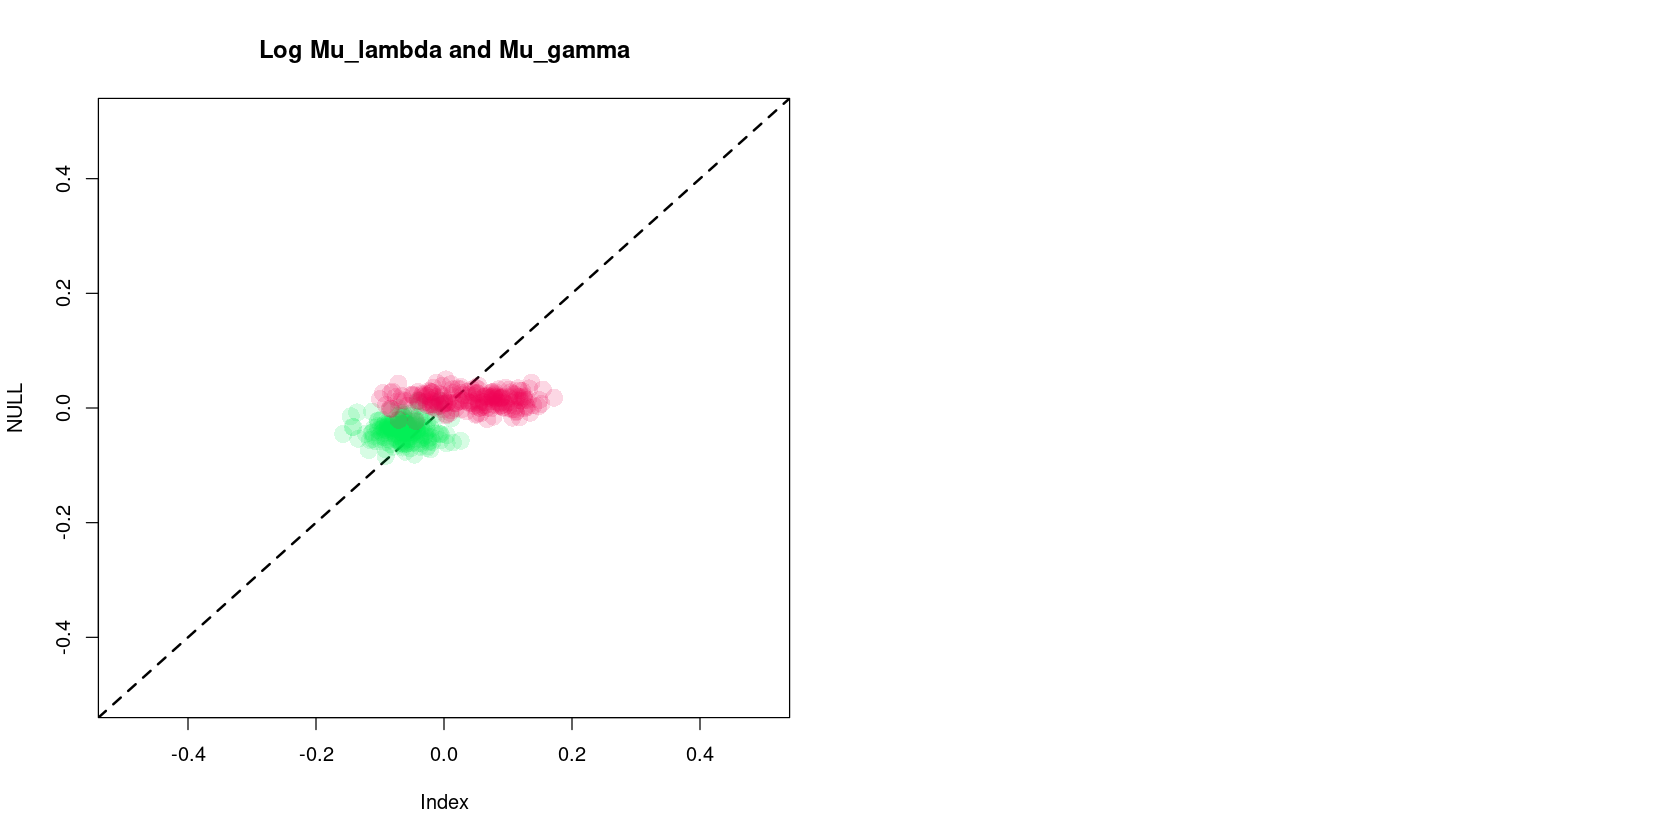

In [98]:
col_matching <- '#00ee55'
col_under <- '#ee0055'

nds <- nds_bayes

options(repr.plot.width=14)
layout(matrix(1:2,ncol = 2))

# Data plot
plot(NULL,xlim=c(-3,3),ylim=c(-3,3),main='Log Data')
abline(0,1,lty='dashed',lwd=2)
points(log(W_r[,1]/W_l[,1]),
       log(B_r[,1]/B_l[,1]),pch=21,bg=paste(col_matching,'aa',sep=''),cex=2,lwd=2)
points(log(W_r[,2]/W_l[,2]),
       log(B_r[,2]/B_l[,2]),pch=21,bg=paste(col_under,'aa',sep=''),cex=2,lwd=2)

# Lambda and Gamma plot (nodes next to data)
sample_index <- sample(dim(nds$gamma_l_post)[1],size=200)
plot(NULL,xlim=c(-3,3),ylim=c(-3,3),main='Log Poisson rates and data')
abline(0,1,lty='dashed',lwd=2)
points(log(nds$gamma_r_post[sample_index,,1]/nds$gamma_l_post[sample_index,,1]),
       log(nds$lambda_r_post[sample_index,,1]/nds$lambda_l_post[sample_index,,1]),
       pch=16,col=paste(col_matching,'08',sep=''),cex=2)
points(log(nds$gamma_r_post[sample_index,,2]/nds$gamma_l_post[sample_index,,2]),
       log(nds$lambda_r_post[sample_index,,2]/nds$lambda_l_post[sample_index,,2]),
       pch=16,col=paste(col_under,'08',sep=''),cex=2)
points(log(W_r[,1]/W_l[,1]),
       log(B_r[,1]/B_l[,1]),pch=21,bg=paste(col_matching,'aa',sep=''),cex=2,lwd=2)
points(log(W_r[,2]/W_l[,2]),
       log(B_r[,2]/B_l[,2]),pch=21,bg=paste(col_under,'aa',sep=''),cex=2,lwd=2)

# Mu_lambda and Mu_gamma plot ('matching distance condition' parameters)
sample_index <- sample(dim(nds$gamma_l_post)[1],size=200)
plot(NULL,xlim=c(-.5,.5),ylim=c(-.5,.5),main='Log Mu_lambda and Mu_gamma')
abline(0,1,lty='dashed',lwd=2)
points(log(nds$mu_gamma_r_post[sample_index,1]/nds$mu_gamma_l_post[sample_index,1]),
       log(nds$mu_lambda_r_post[sample_index,1]/nds$mu_lambda_l_post[sample_index,1]),
       pch=16,col=paste(col_matching,'28',sep=''),cex=2)
points(log(nds$mu_gamma_r_post[sample_index,2]/nds$mu_gamma_l_post[sample_index,2]),
       log(nds$mu_lambda_r_post[sample_index,2]/nds$mu_lambda_l_post[sample_index,2]),
       pch=16,col=paste(col_under,'28',sep=''),cex=2)
# points(log(W_r[,1]/W_l[,1]),
#        log(B_r[,1]/B_l[,1]),pch=21,bg=paste(col_matching,'aa',sep=''),cex=2,lwd=2)
# points(log(W_r[,2]/W_l[,2]),
#        log(B_r[,2]/B_l[,2]),pch=21,bg=paste(col_under,'aa',sep=''),cex=2,lwd=2)

